In [1]:
## Environment Setup

In [2]:
#!pip install folium

In [32]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *

# Business Objectives

Main question: How prepared is Germany for the upcoming EU ban of diesel and petrol cars?

## Datasets

### Number of charging stations in Germany
https://www.bundesnetzagentur.de/DE/Fachthemen/ElektrizitaetundGas/E-Mobilitaet/start.html
#### Number of electrical cars in Germany
 - to be used to create ratio of charging station : number of cars
https://www.kba.de/DE/Statistik/Fahrzeuge/Neuzulassungen/neuzulassungen_node.html


In [33]:
df = pd.read_csv('./raw_data/charging_stations_per_state.csv')
df

,land,regular_charging_points,fast_charging_points,number_of_charging_points,year
0,Baden-Württemberg,"1,106",241,"1,347",2018
1,Bayern,"2,138",363,"2,501",2018
2,Berlin,612,26,638,2018
3,Brandenburg,88,28,116,2018
4,Bremen,67,4,71,2018
...,...,...,...,...,...
131,Sachsen,"4,373","1,424","5,797",2025
132,Sachsen-Anhalt,"1,840",910,"2,750",2025
133,Schleswig-Holstein,"5,017","1,499","6,516",2025
134,Thüringen,"2,154","1,157","3,311",2025


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   land                       136 non-null    object
 1   regular_charging_points    136 non-null    object
 2   fast_charging_points       136 non-null    object
 3   number_of_charging_points  136 non-null    object
 4   year                       136 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 5.4+ KB


In [35]:
df["regular_charging_points"] = df["regular_charging_points"].str.replace(",", "").astype(int)
df["fast_charging_points"] = df["fast_charging_points"].str.replace(",", "").astype(int)
df["number_of_charging_points"] = df["number_of_charging_points"].str.replace(",", "").astype(int)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   land                       136 non-null    object
 1   regular_charging_points    136 non-null    int64 
 2   fast_charging_points       136 non-null    int64 
 3   number_of_charging_points  136 non-null    int64 
 4   year                       136 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.4+ KB


### Data wrangling

Convert string to datetime

Extract month and year from commission_date

In [37]:
df['land'].value_counts()

land
Baden-Württemberg         8
Bayern                    8
Berlin                    8
Brandenburg               8
Bremen                    8
Hamburg                   8
Hessen                    8
Mecklenburg-Vorpommern    8
Niedersachsen             8
Nordrhein-Westfalen       8
Rheinland-Pfalz           8
Saarland                  8
Sachsen                   8
Sachsen-Anhalt            8
Schleswig-Holstein        8
Thüringen                 8
Deutschland               8
Name: count, dtype: int64

In [38]:
df_germany = df[df["land"] == 'Deutschland']


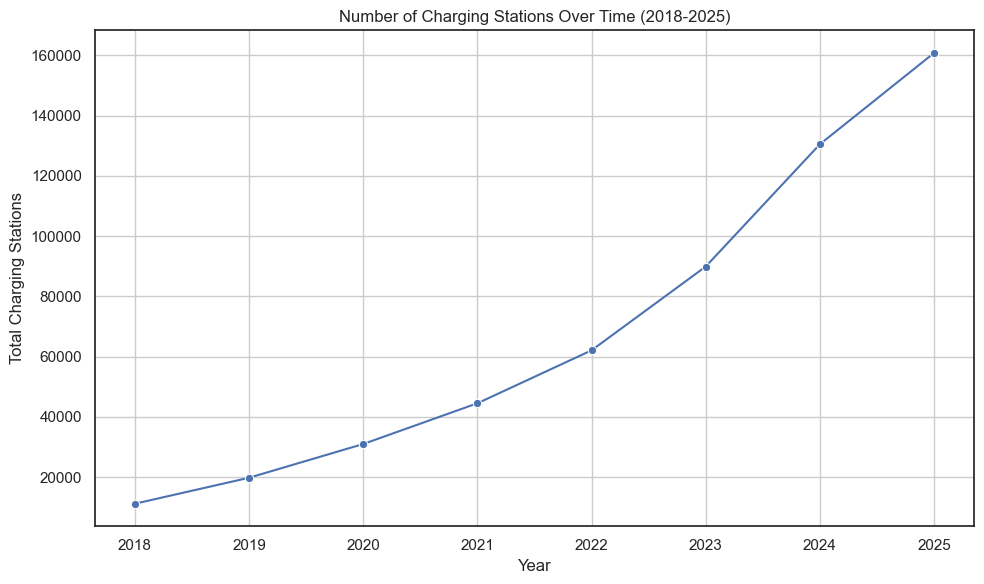

In [48]:
yearly_counts = df_germany["number_of_charging_points"].sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data = df_germany, x="year", y = yearly_counts, marker='o')
plt.title("Number of Charging Stations Over Time (2018-2025)")
plt.xlabel("Year")
plt.ylabel("Total Charging Stations")
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# Count the number of stations per state
df_only_states = df[~(df["land"] == "Deutschland")]
df_only_states


,land,regular_charging_points,fast_charging_points,number_of_charging_points,year
0,Baden-Württemberg,1106,241,1347,2018
1,Bayern,2138,363,2501,2018
2,Berlin,612,26,638,2018
3,Brandenburg,88,28,116,2018
4,Bremen,67,4,71,2018
...,...,...,...,...,...
130,Saarland,942,286,1228,2025
131,Sachsen,4373,1424,5797,2025
132,Sachsen-Anhalt,1840,910,2750,2025
133,Schleswig-Holstein,5017,1499,6516,2025


In [41]:
# Count the number of stations per state
df_only_states = df[~(df["land"] == "Deutschland")]
stations_per_state = df_only_states.groupby("land").agg(
    number_of_stations=("number_of_charging_points", "sum")     
).reset_index()

stations_per_state

,land,number_of_stations
0,Baden-Württemberg,93695
1,Bayern,111983
2,Berlin,18854
3,Brandenburg,12340
4,Bremen,3969
5,Hamburg,14077
6,Hessen,41655
7,Mecklenburg-Vorpommern,6887
8,Niedersachsen,54124
9,Nordrhein-Westfalen,101969


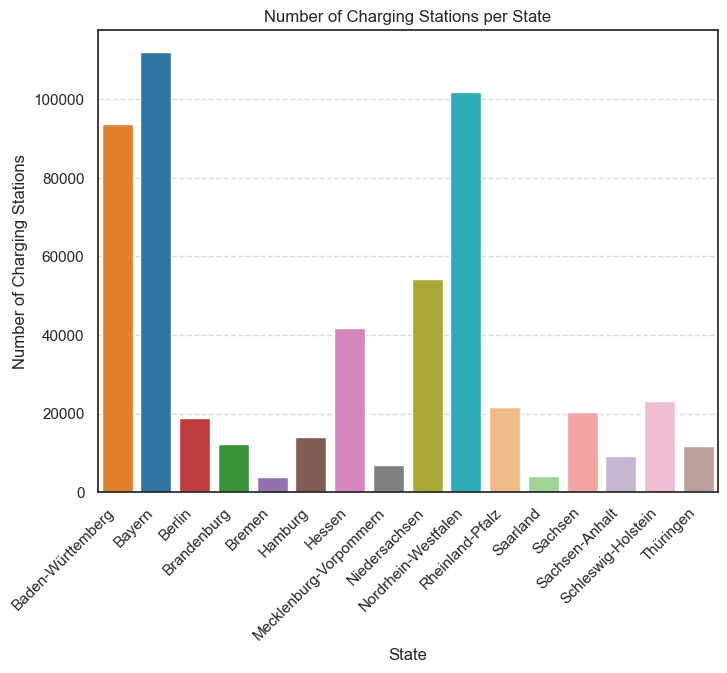

In [42]:

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(data=stations_per_state, x="land", y="number_of_stations", palette=german_states_colors)

plt.title("Number of Charging Stations per State")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Create a Summary Dataframe

Groups number of charging stations, number of charging points, number of fast charging stations, number of regular charging stations per state

In [43]:
# Create the summary DataFrame
df_stations_per_state = df_only_states.groupby("land").agg(
    number_of_charging_points=("number_of_charging_points", "sum"),    
    number_fast_charging_stations=("fast_charging_points", "sum"),
    number_regular_charging_stations=("regular_charging_points", "sum")
).reset_index()


df_stations_per_state.head()


,land,number_of_charging_points,number_fast_charging_stations,number_regular_charging_stations
0,Baden-Württemberg,93695,14271,79424
1,Bayern,111983,19649,92334
2,Berlin,18854,2325,16529
3,Brandenburg,12340,2897,9443
4,Bremen,3969,537,3432


In [44]:
df_stations_per_state.rename(columns = {"land":"state"}, inplace = True)
df_stations_per_state.to_csv('./clean_data/stations_per_state.csv', index=False)

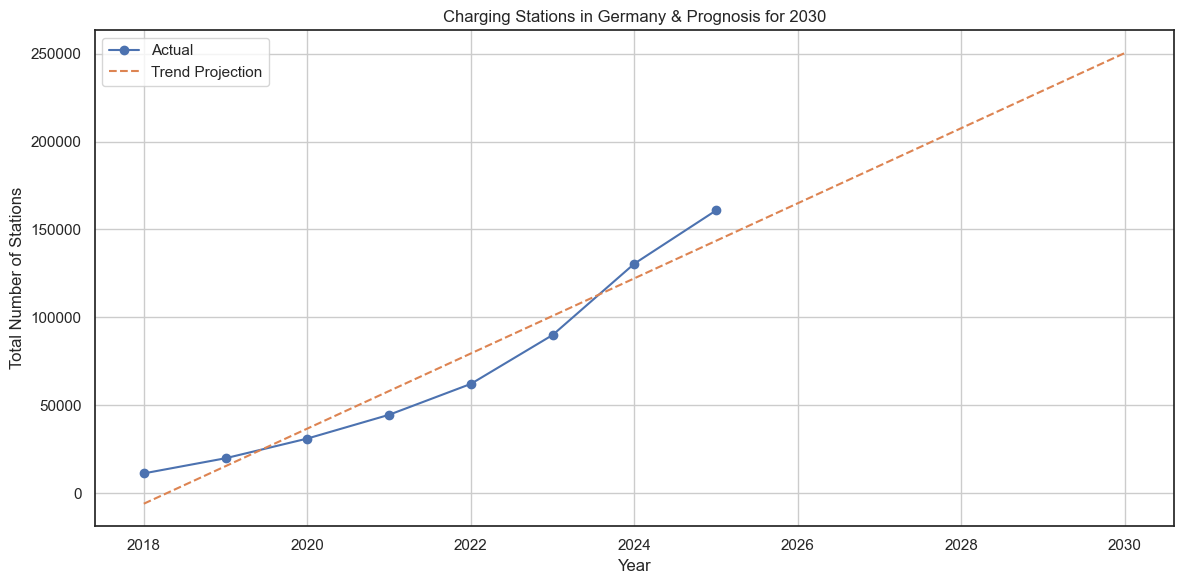

To reach 1,000,000 stations by 2030, Germany needs ~167,838 new stations per year from 2026.


In [45]:
from sklearn.linear_model import LinearRegression
df = df_germany.copy()

# Step 1: Linear regression for projection
X = df["year"].values.reshape(-1, 1)
y = df["number_of_charging_points"].values

model = LinearRegression()
model.fit(X, y)

# Predict future until 2030
future_years = np.arange(df["year"].min(), 2031).reshape(-1, 1)
predictions = model.predict(future_years)

# Calculate remaining needed to hit the 2030 target
last_known_year = df["year"].max()
last_known_count = df[df["year"] == last_known_year]["number_of_charging_points"].values[0]
stations_needed = 1_000_000 - last_known_count
years_remaining = 2030 - last_known_year
stations_per_year_needed = stations_needed / years_remaining

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df["year"], df["number_of_charging_points"], label="Actual", marker="o")

# Add values above markers
#for x, y_val in zip(df["year"], df["number_of_charging_points"]):
#    plt.text(x, y_val + 3000, f"{y_val:,}", ha='center', fontsize=9)

# Plot projection
plt.plot(future_years.flatten(), predictions, linestyle="--", label="Trend Projection")

# Add target line
#plt.axhline(1_000_000, color="red", linestyle=":", label="Target: 1M by 2030")

plt.title("Charging Stations in Germany & Prognosis for 2030")
plt.xlabel("Year")
plt.ylabel("Total Number of Stations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output key metric
print(f"To reach 1,000,000 stations by 2030, Germany needs ~{int(stations_per_year_needed):,} new stations per year from {last_known_year + 1}.")